In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

In [2]:
# Load datasets
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()  # Convert DataFrame to Series
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

X_train_bal = pd.read_csv("../data/processed/X_train_bal.csv")
y_train_bal = pd.read_csv("../data/processed/y_train_bal.csv").squeeze()

In [3]:
# Confirm shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))

print("Balanced training set shape:", X_train_bal.shape)
print("Balanced target distribution:\n", y_train_bal.value_counts(normalize=True))

X_train shape: (26064, 22)
X_test shape: (6517, 22)
y_train distribution:
 loan_status
0    0.781845
1    0.218155
Name: proportion, dtype: float64
y_test distribution:
 loan_status
0    0.781801
1    0.218199
Name: proportion, dtype: float64
Balanced training set shape: (40756, 22)
Balanced target distribution:
 loan_status
0    0.5
1    0.5
Name: proportion, dtype: float64


## Logistic Regression

### Training on original training data

Logistic Regression - Original Data
Accuracy: 0.8686512198864508
ROC AUC: 0.8694888538306632

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      5095
           1       0.77      0.57      0.65      1422

    accuracy                           0.87      6517
   macro avg       0.83      0.76      0.79      6517
weighted avg       0.86      0.87      0.86      6517



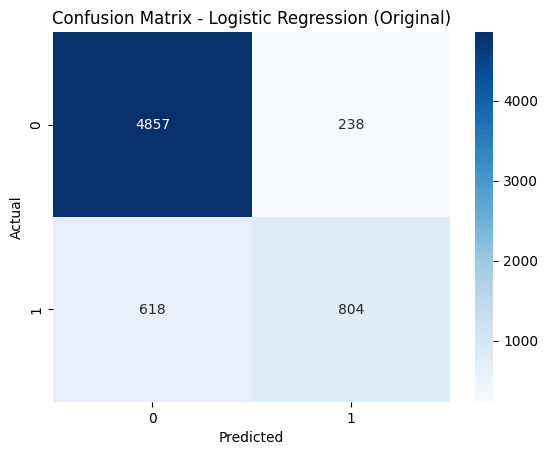

In [4]:
# Initialize the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Train on original training data
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print("Logistic Regression - Original Data")
print("Accuracy:", log_reg.score(X_test, y_test))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (Original)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Training on balanced training data


Logistic Regression - SMOTE Balanced Data
Accuracy: 0.8143317477366887
ROC AUC: 0.8715360333688057

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87      5095
           1       0.55      0.78      0.65      1422

    accuracy                           0.81      6517
   macro avg       0.74      0.80      0.76      6517
weighted avg       0.85      0.81      0.82      6517



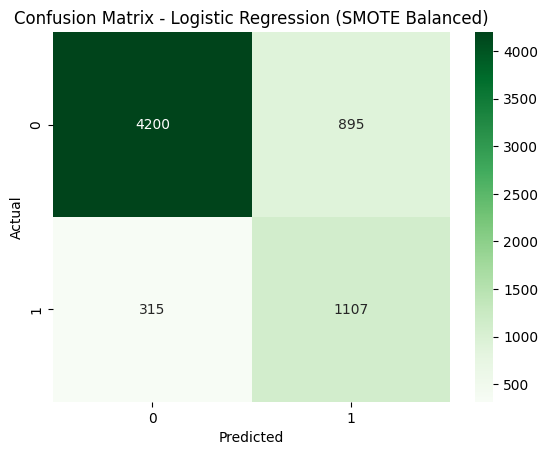

In [5]:
# Train on balanced training data
log_reg_bal = LogisticRegression(random_state=42, max_iter=1000)
log_reg_bal.fit(X_train_bal, y_train_bal)
y_pred_bal = log_reg_bal.predict(X_test)
y_proba_bal = log_reg_bal.predict_proba(X_test)[:, 1]

print("\nLogistic Regression - SMOTE Balanced Data")
print("Accuracy:", log_reg_bal.score(X_test, y_test))
print("ROC AUC:", roc_auc_score(y_test, y_proba_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_bal), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Logistic Regression (SMOTE Balanced)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Cross-Validation and Model Validation

In [6]:
# Initialize Stratified K-Folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-Validation on Original Data
log_reg = LogisticRegression(random_state=42, max_iter=1000)

cv_scores_auc = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='roc_auc')
cv_scores_acc = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='accuracy')

print("Logistic Regression - Original Data")
print("Mean ROC AUC:", round(cv_scores_auc.mean(), 4))
print("Mean Accuracy:", round(cv_scores_acc.mean(), 4))

Logistic Regression - Original Data
Mean ROC AUC: 0.8693
Mean Accuracy: 0.8667


In [7]:
# Cross-Validation on SMOTE-balanced Data
log_reg_bal = LogisticRegression(random_state=42, max_iter=1000)

cv_scores_auc_bal = cross_val_score(log_reg_bal, X_train_bal, y_train_bal, cv=cv, scoring='roc_auc')
cv_scores_acc_bal = cross_val_score(log_reg_bal, X_train_bal, y_train_bal, cv=cv, scoring='accuracy')

print("\nLogistic Regression - SMOTE Balanced Data")
print("Mean ROC AUC:", round(cv_scores_auc_bal.mean(), 4))
print("Mean Accuracy:", round(cv_scores_acc_bal.mean(), 4))


Logistic Regression - SMOTE Balanced Data
Mean ROC AUC: 0.8759
Mean Accuracy: 0.8011


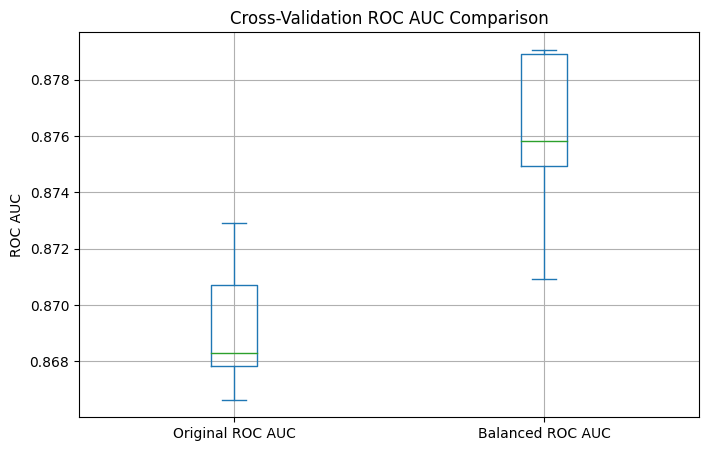

In [8]:
cv_results = pd.DataFrame({
    'Original ROC AUC': cv_scores_auc,
    'Balanced ROC AUC': cv_scores_auc_bal
})

cv_results.plot(kind='box', figsize=(8, 5), title='Cross-Validation ROC AUC Comparison')
plt.ylabel("ROC AUC")
plt.grid(True)
plt.show()

### Hyperparameter Tuning (GridSearchCV) for Logistic Regression on the SMOTE-balanced data

In [9]:
# Define model and parameter grid
log_reg = LogisticRegression(random_state=42, max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit on balanced training data
grid_search.fit(X_train_bal, y_train_bal)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", round(grid_search.best_score_, 4))

Best Parameters: {'C': 100}
Best ROC AUC Score: 0.8761


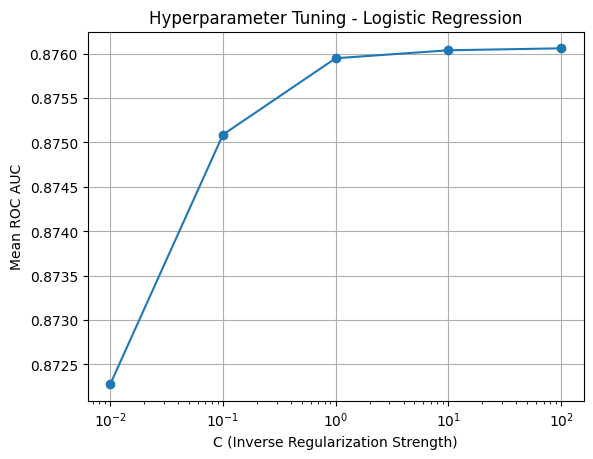

In [10]:
results_df = pd.DataFrame(grid_search.cv_results_)
plt.plot(results_df['param_C'], results_df['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Mean ROC AUC')
plt.title('Hyperparameter Tuning - Logistic Regression')
plt.grid(True)
plt.show()

In [11]:
# Use best model from GridSearchCV
best_log_reg = grid_search.best_estimator_

# Predict on test set
y_pred = best_log_reg.predict(X_test)
y_proba = best_log_reg.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      5095
           1       0.55      0.78      0.65      1422

    accuracy                           0.81      6517
   macro avg       0.74      0.80      0.76      6517
weighted avg       0.85      0.81      0.82      6517



Confusion Matrix:


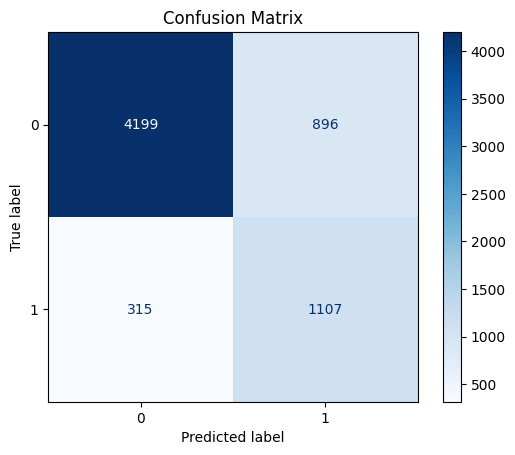

In [12]:
# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_log_reg.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("../reports/figures/Logistic Regression - Confusion Matrix.png")
plt.show()

ROC AUC Score: 0.8716


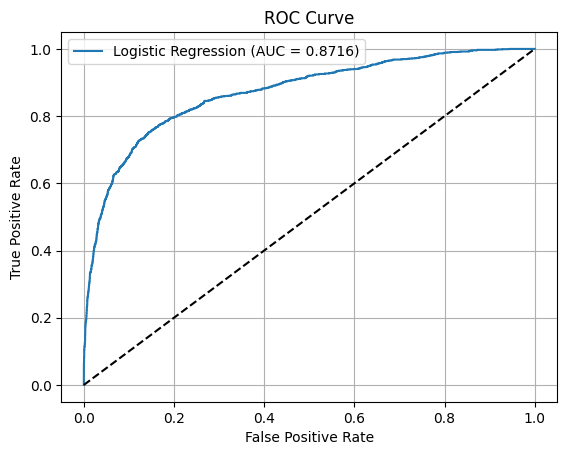

In [14]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

## Random Forest Classifier

### Train Random Forest Classifier (with GridSearchCV)

In [15]:
# Define model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Hyperparameters to tune
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params,
                       cv=5, scoring='f1', n_jobs=-1, verbose=1)

rf_grid.fit(X_train_bal, y_train_bal)
print(f"Best Random Forest Parameters:\n{rf_grid.best_params_}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Random Forest Parameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Evaluate on Test Set

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.93      0.73      0.82      1422

    accuracy                           0.93      6517
   macro avg       0.93      0.86      0.89      6517
weighted avg       0.93      0.93      0.93      6517



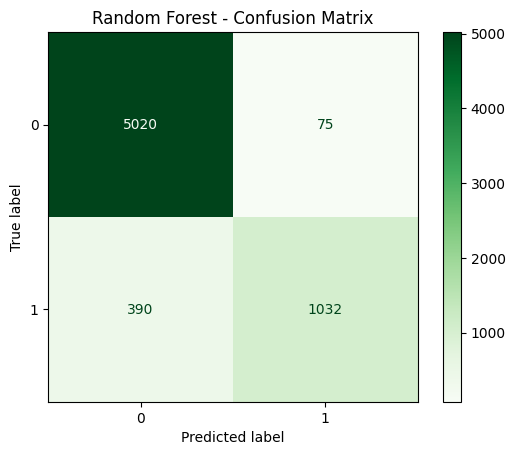

Random Forest ROC AUC Score: 0.9312


In [16]:
# Best RF model
best_rf = rf_grid.best_estimator_

# Predict
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Classification Report
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=best_rf.classes_)
disp_rf.plot(cmap='Greens')
plt.title("Random Forest - Confusion Matrix")
plt.savefig("../reports/figures/Random Forest - Confusion Matrix.png")
plt.show()

# ROC AUC
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"Random Forest ROC AUC Score: {roc_auc_rf:.4f}")

### Compare ROC Curves

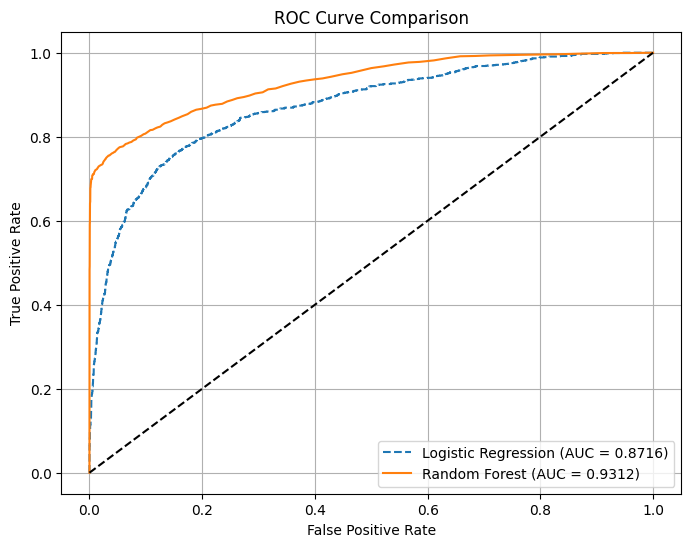

In [18]:
# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba)
# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc:.4f})", linestyle='--')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})", linestyle='-')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.savefig("../reports/figures/ROC Curve Comparison.png")
plt.show()

## Model Comparison Summary

After performing hyperparameter tuning and rigorous evaluation on the test set, the two models was compared: **Logistic Regression** and **Random Forest Classifier**. Below are the highlights:

1. **Logistic Regression**

    - **Best Hyperparameters:** {'C': 100}

    - **ROC AUC Score:** 0.8761

    - **Accuracy:** 81%

    - **Precision (Class 1):** 0.55

    - **Recall (Class 1):** 0.78

    - **F1-score (Class 1):** 0.65

    Logistic Regression provides decent recall for the positive class (78%), which is important in a loan default prediction scenario, though its precision is relatively low (55%), indicating a higher rate of false positives.


2. **Random Forest Classifier**

    - **Best Hyperparameters:** {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

    - **ROC AUC Score:** 0.9312

    - **Accuracy:** ~92.8%

    - **Precision (Class 1):** 0.93

    - **Recall (Class 1):** 0.73

    - **F1-score (Class 1):** 0.82

    Random Forest outperformed Logistic Regression across almost all metrics, especially in ROC AUC (93.1%) and precision for the positive class. It maintained a stronger balance between false positives and false negatives, making it a more reliable choice for production deployment.

## Conclusion

While Logistic Regression is simpler and easier to interpret, the Random Forest Classifier clearly demonstrated superior predictive performance in both AUC and classification metrics. For this loan default prediction task, Random Forest is better suited as the final model.

## Final Model Selection and Saving

In [21]:
# Save the final Random Forest model
joblib.dump(best_rf, '../models/final_random_forest_model.joblib')

# Save the feature columns
joblib.dump(X_train.columns.tolist(), '../models/feature_columns.joblib')

['../models/feature_columns.joblib']